In [25]:
import pymc as pm
import numpy as np
from datetime import datetime
import yfinance as yf 
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

In [2]:
np.random.seed(101)

In [3]:
start = datetime(2022, 11, 15)
end = datetime(2022, 12, 31)

In [4]:
market = yf.Ticker('SPY').history(start=start,end=end)
stock = yf.Ticker('AAPL').history(start=start,end=end)
risk_free_rate = yf.Ticker('^TNX').history(start=start,end=end)

In [5]:
daily_returns = pd.DataFrame()

In [6]:
daily_returns['market'] = market['Close'].pct_change(1)*100
daily_returns['stock'] = stock['Close'].pct_change(1)*100

In [7]:
daily_returns['riskfree'] = (1 + risk_free_rate['Close'])**(1/360)-1

In [8]:
market.index.difference(risk_free_rate.index)

DatetimeIndex([], dtype='datetime64[ns, America/New_York]', name='Date', freq=None)

In [9]:
# 欠損値埋め
daily_returns = daily_returns.ffill()

In [10]:
daily_returns = daily_returns.dropna()

In [11]:
daily_returns.isnull().sum()

market      0
stock       0
riskfree    0
dtype: int64

In [12]:
daily_returns.head()

,market,stock,riskfree
Date,,,
2022-11-16 00:00:00-05:00,-0.762865,-0.833105,0.004303
2022-11-17 00:00:00-05:00,-0.305987,1.297147,0.004352
2022-11-18 00:00:00-05:00,0.454042,0.378186,0.004377
2022-11-21 00:00:00-05:00,-0.363616,-2.168039,0.004381
2022-11-22 00:00:00-05:00,1.345695,1.466111,0.004342


In [13]:
# 超過リターンを計算
y = daily_returns['stock'] - daily_returns['riskfree']
x = daily_returns['market'] - daily_returns['riskfree']

Text(0.5, 0, 'Exscess returns of S&P500')

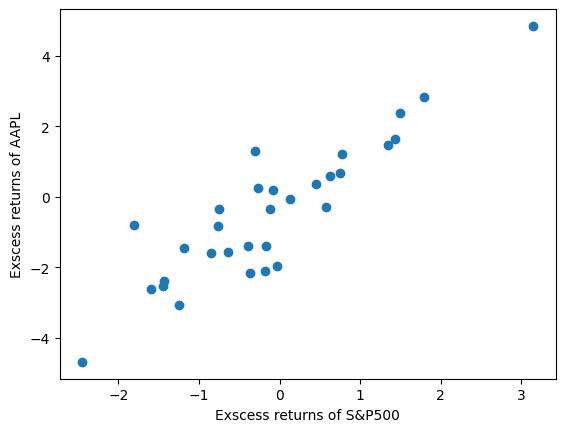

In [14]:
# プロット
plt.scatter(x,y)
plt.ylabel('Exscess returns of AAPL')
plt.xlabel('Exscess returns of S&P500')

(array([0.03379698, 0.03379698, 0.20278188, 0.1689849 , 0.20278188,
        0.1689849 , 0.13518792, 0.06759396, 0.        , 0.03379698]),
 array([-4.6895902 , -3.73512432, -2.78065845, -1.82619257, -0.8717267 ,
         0.08273918,  1.03720505,  1.99167093,  2.94613681,  3.90060268,
         4.85506856]),
 <BarContainer object of 10 artists>)

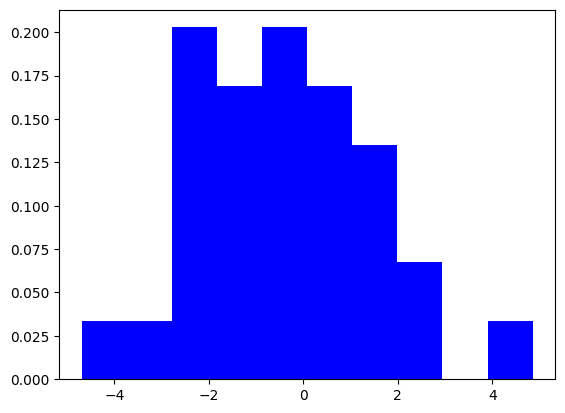

In [15]:
plt.hist(y, density=True, color='blue')

In [16]:
daily_returns.describe()

,market,stock,riskfree
count,31.000000,31.000000,31.000000
mean,-0.110989,-0.444417,0.004282
std,1.192475,1.967496,0.000083
min,-2.446162,-4.685435,0.004129
25%,-0.805413,-1.775158,0.004200
50%,-0.171746,-0.343486,0.004299
75%,0.602700,0.635450,0.004340
max,3.150072,4.859378,0.004417


In [17]:
test_size = 10

x_train = x[:-test_size]
y_train = y[:-test_size]

x_test = x[-test_size:]
y_test = y[-test_size:]

In [20]:
model = pm.Model()
with model:
    alpha = pm.Normal('alpha',mu=0.02,sigma=0.10)
    beta = pm.Normal('beta',mu=1.2,sigma=0.15)
    residual = pm.HalfStudentT('residual',sigma=0.20,nu=6)
    feature = pm.MutableData('feature',x_train,dims='feature_data')
    target = pm.MutableData('target',y_train,dims='target_data')
    target_expected = pm.Deterministic('target_expected',alpha + beta * feature, dims='feature_data')
    target_likelihood = pm.StudentT('target_likelihood', mu=target_expected,sigma=residual,nu=6,observed=target,dims='target_data')

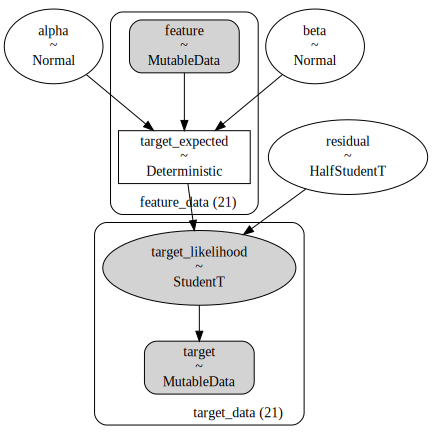

In [22]:
pm.model_to_graphviz(model)

In [23]:
idata = pm.sample_prior_predictive(samples=1000,model=model,return_inferencedata=True,random_seed=28)

Sampling: [alpha, beta, residual, target_likelihood]


In [24]:
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

array([[<AxesSubplot: title={'center': 'alpha'}>,
        <AxesSubplot: title={'center': 'alpha'}>],
       [<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>],
       [<AxesSubplot: title={'center': 'residual'}>,
        <AxesSubplot: title={'center': 'residual'}>]], dtype=object)

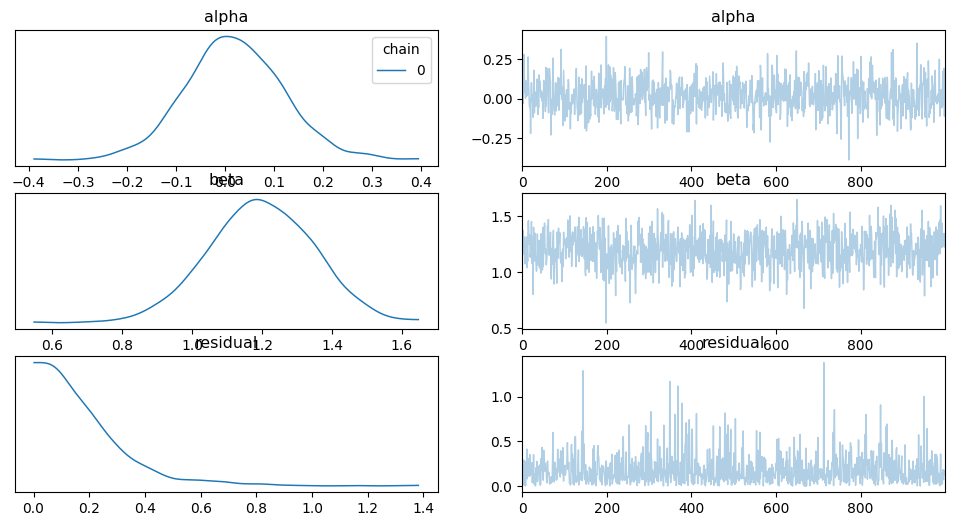

In [29]:
az.plot_trace(idata.prior,kind='trace',var_names=['alpha','beta','residual'],legend=True)

array([<AxesSubplot: title={'center': 'alpha'}>,
       <AxesSubplot: title={'center': 'beta'}>,
       <AxesSubplot: title={'center': 'residual'}>], dtype=object)

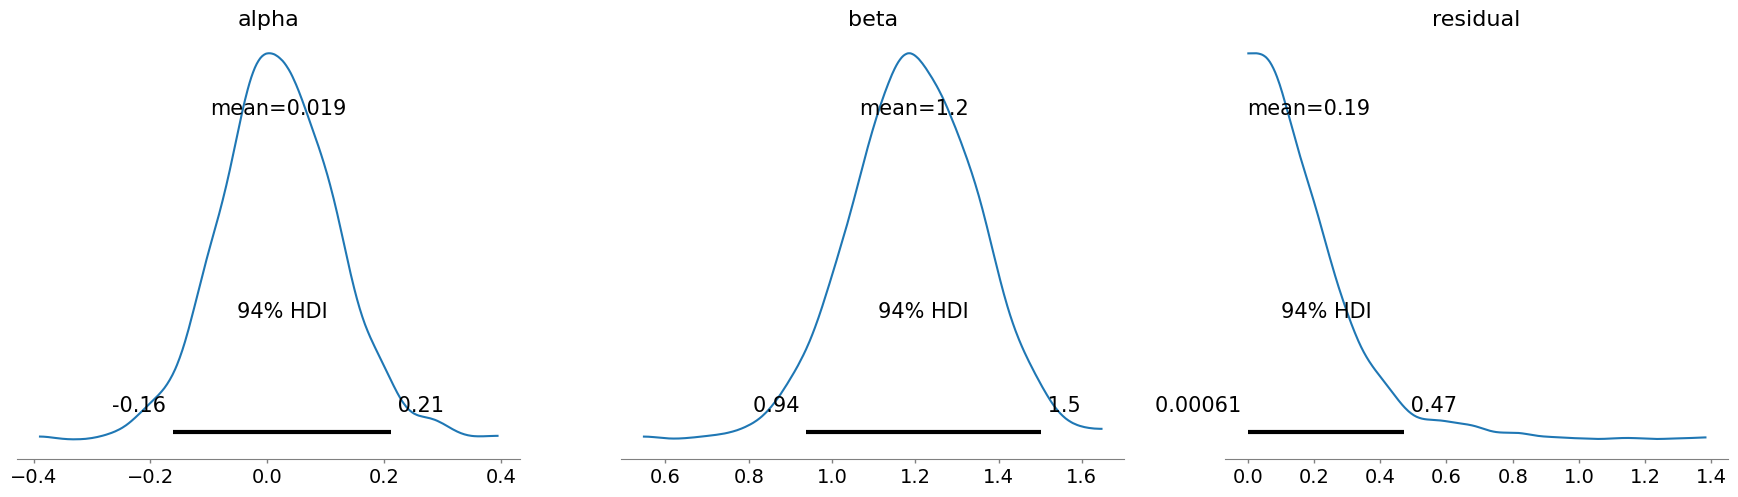

In [30]:
az.plot_posterior(idata.prior,var_names=['alpha','beta','residual'],round_to=2)

array([[<AxesSubplot: >, None],
       [<AxesSubplot: xlabel='alpha', ylabel='beta'>, <AxesSubplot: >]],
      dtype=object)

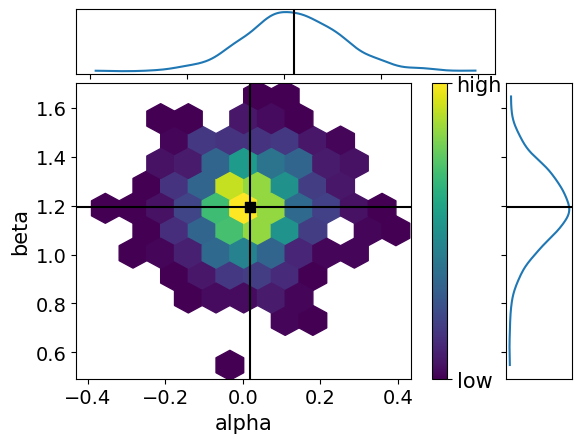

In [31]:
az.plot_pair(idata.prior,var_names=['alpha','beta'],kind='hexbin',marginals=True,point_estimate='mean',colorbar=True)

In [32]:
feature_train = idata.constant_data['feature']
target_train = idata.constant_data['target']

In [33]:
prior_target = idata.prior['alpha'] + idata.prior['beta']*feature_train
prior_predictive = idata.prior_predictive['target_likelihood']

Text(0, 0.5, 'Excess return of AAPL')

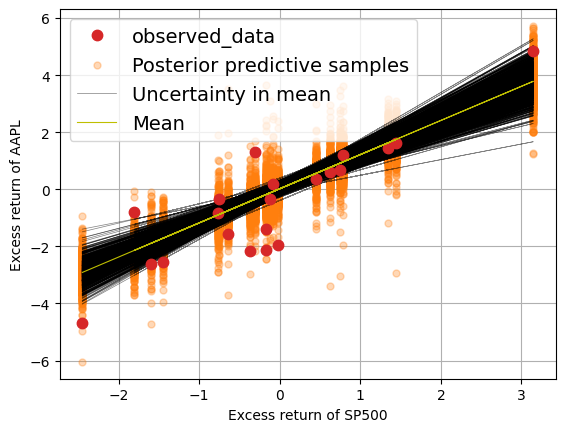

In [37]:
fig, ax = plt.subplots()

az.plot_lm(idata=idata,x=feature_train,y=target_train,num_samples=1000,y_model=prior_target,y_hat=prior_predictive,axes=ax)
ax.set_xlabel('Excess return of SP500')
ax.set_ylabel('Excess return of AAPL')

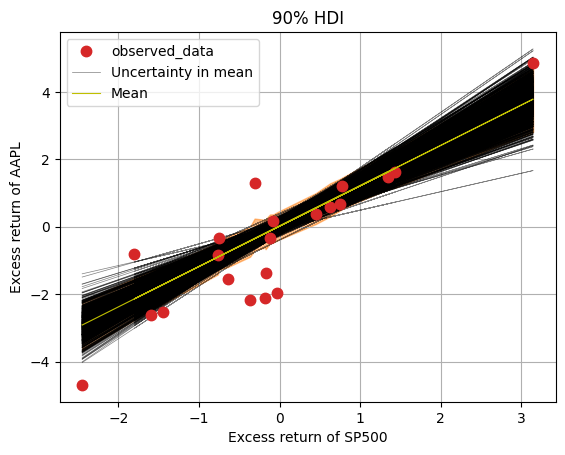

In [39]:
fig, ax = plt.subplots()

az.plot_lm(idata=idata, x=feature_train, y=target_train, num_samples=1000, y_model=prior_target, axes=ax)
az.plot_hdi(feature_train, prior_predictive, hdi_prob=0.90, smooth=False)

ax.set_xlabel('Excess return of SP500')
ax.set_ylabel('Excess return of AAPL')
ax.set_title('90% HDI')
ax.legend();